In [1]:
'''
This routine detects heatwave events at specific geographical points using the rule fo at least 5 consecutive days of maximum temperature 5degC above the mean

Daniela Risaro
July 2025
'''


'\nThis routine detects heatwave events at specific geographical points using the rule fo at least 5 consecutive days of maximum temperature 5degC above the mean\n\nDaniela Risaro\nJuly 2025\n'

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import os 
import random 

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

file_percentiles = 'tmax2m_mean_and_percentiles_1960_1989.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_mean_and_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)

value_mean = ds_mean_and_percentiles[f't2m_mean']
# target year, i chose one at random 
target_year = random.randint(1980, 2024)
target_year = 2022

ds_year = xr.open_dataset(data_raw_dir + [f for f in files_raw if str(target_year) in f][0])
ds_year = ds_year["t2m"] - 273.15  # convertir a Celsius

print('Año seleccionado:', target_year)

# select a random gridpoint 
lat_idx = random.randint(0, len(ds_mean_and_percentiles.latitude) - 1)
lon_idx = random.randint(0, len(ds_mean_and_percentiles.longitude) - 1)

lat_idx = 95
lon_idx = 30

lat_value = ds_mean_and_percentiles.latitude.values[lat_idx]
lon_value = ds_mean_and_percentiles.longitude.values[lon_idx]
print(f'Gridpoint seleccionado: lat_idx={lat_idx}, lon_idx={lon_idx}, lat={lat_value}, lon={lon_value}')

target_year_point = ds_year.isel(latitude=lat_idx, longitude=lon_idx)
target_year_point['doy'] = target_year_point['valid_time'].dt.dayofyear

value_mean_point = value_mean.isel(latitude=lat_idx, longitude=lon_idx)
threshold = value_mean_point.sel(doy=target_year_point['doy'])

# detect events
excess = target_year_point - threshold
exceeds = excess > 3

df = pd.DataFrame({
    "date": target_year_point["valid_time"].values,
    "tmax": target_year_point.values,
    "threshold": threshold.values,
    "exceeds": exceeds.values
})

df["group"] = (df["exceeds"] != df["exceeds"].shift()).cumsum()     # shift one day to the right
df["event_dummy"] = 0
df["magnitude_event"] = np.nan
df["anomaly_event"] = np.nan

for _, group_df in df[df["exceeds"]].groupby("group"):
    if len(group_df) >= 3:
        idxs = group_df.index
        df.loc[idxs, "event_dummy"] = 1
        df.loc[idxs, "magnitude_event"] = df.loc[idxs, "tmax"]
        df.loc[idxs, "anomaly_event"] = df.loc[idxs, "tmax"] - df.loc[idxs, "threshold"]


Año seleccionado: 2022
Gridpoint seleccionado: lat_idx=95, lon_idx=30, lat=21.25, lon=-87.5


In [3]:
# export .csv for this random point 
df.to_csv(f'../outputs/events_climanom/heatwave_events_year{target_year}_lat{lat_value}_lon{lon_value}_mean.csv')

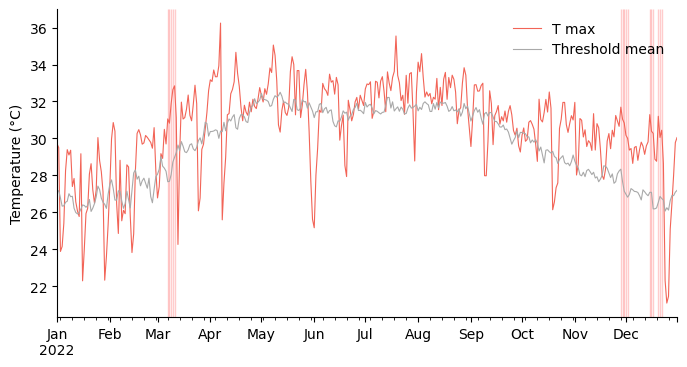

In [12]:
# plot the data 

ax = df.set_index("date")[["tmax", "threshold"]].plot(figsize=(8, 4), 
                                                     color=['#F26457', 'darkgray'],
                                                     linewidth=0.8)
ax.lines[0].set_label('T max')
ax.lines[1].set_label(f'Threshold mean')
ax.legend(loc='upper right', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('')

for idx in df[df["event_dummy"] == 1].index:
    ax.axvspan(df.loc[idx, "date"], df.loc[idx, "date"], 
               alpha=0.2, color='red')

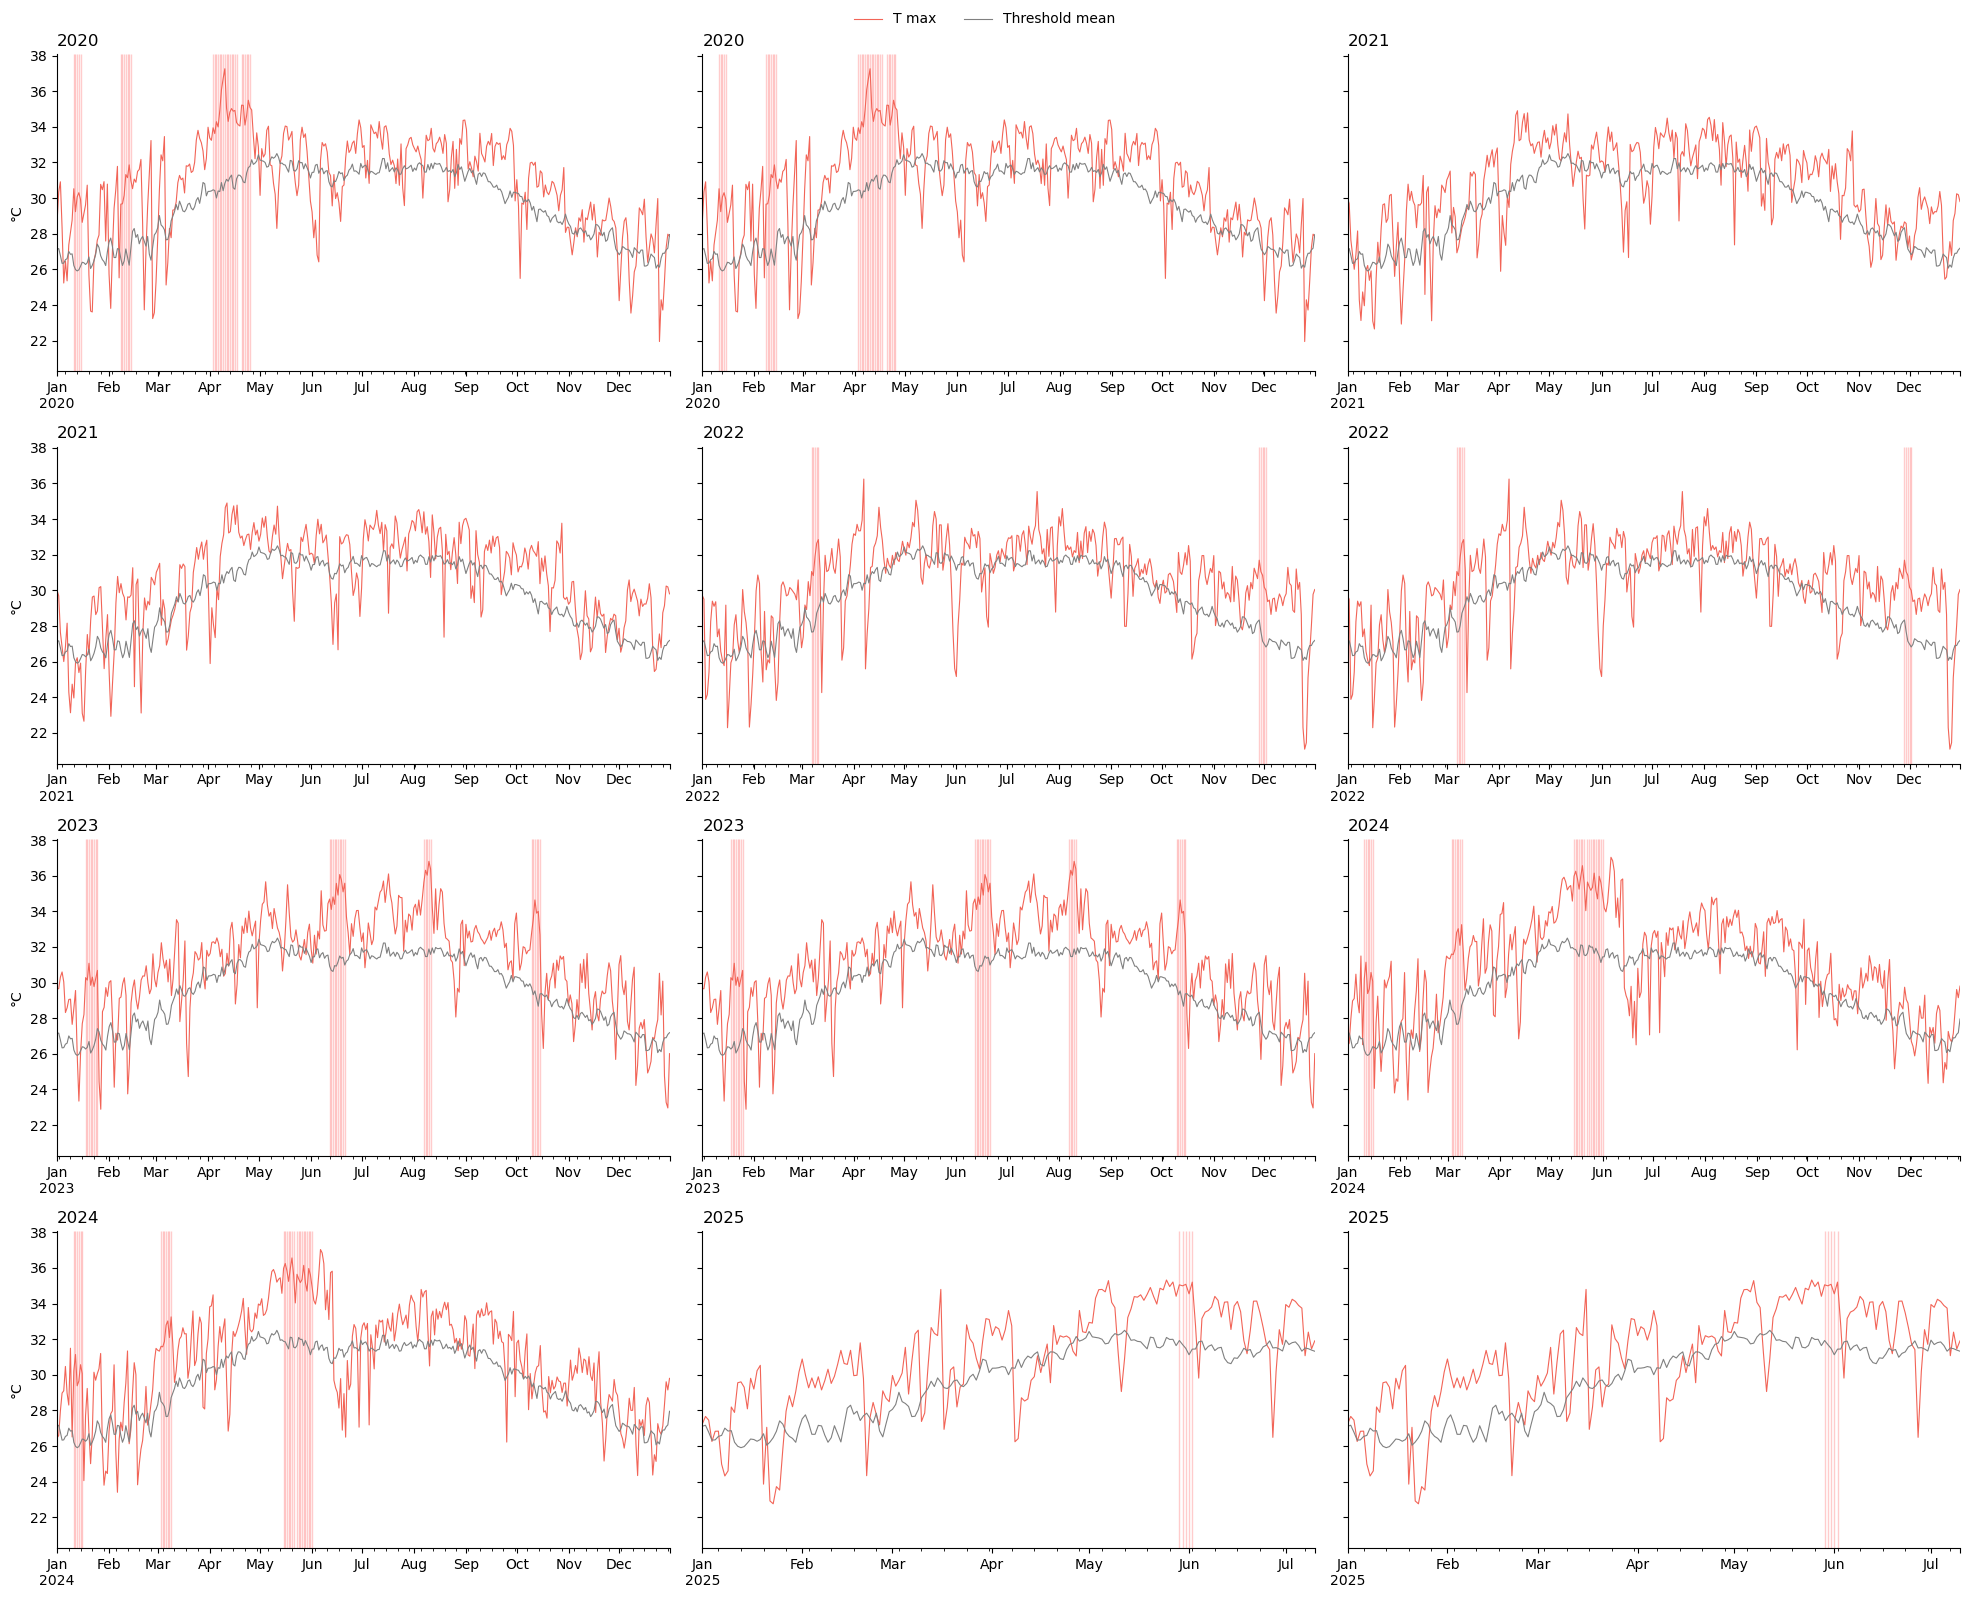

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

file_percentiles = 'tmax2m_mean_and_percentiles_1960_1989.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_mean_and_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)
value_mean = ds_mean_and_percentiles[f't2m_mean']

# Elegir un punto fijo
lat_idx = 95
lon_idx = 30
lat_value = ds_mean_and_percentiles.latitude.values[lat_idx]
lon_value = ds_mean_and_percentiles.longitude.values[lon_idx]

# Obtener lista de años
years = sorted([int(f.split("_")[-1].split(".")[0]) for f in files_raw])
years = [year for year in years if year > 2019]


# Crear subplots
n_cols = 3
n_rows = int(np.ceil(len(years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharey=True)
axes = axes.flatten()

# Guardar una línea representativa para la leyenda global
line_tmax, line_threshold = None, None

for i, year in enumerate(years):

    ds_year = xr.open_dataset(os.path.join(data_raw_dir, f"era5_tmax_daily_{year}.nc"))
    ds_year = ds_year["t2m"] - 273.15

    target_year_point = ds_year.isel(latitude=lat_idx, longitude=lon_idx)
    target_year_point['doy'] = target_year_point['valid_time'].dt.dayofyear

    value_mean_point = value_mean.isel(latitude=lat_idx, longitude=lon_idx)
    threshold = value_mean_point.sel(doy=target_year_point['doy'])

    excess = target_year_point - threshold
    exceeds = excess > 3

    df = pd.DataFrame({
        "date": target_year_point["valid_time"].values,
        "tmax": target_year_point.values,
        "threshold": threshold.values,
        "exceeds": exceeds.values
    })

    df["group"] = (df["exceeds"] != df["exceeds"].shift()).cumsum()
    df["event_dummy"] = 0
    for _, group_df in df[df["exceeds"]].groupby("group"):
        if len(group_df) >= 5:
            df.loc[group_df.index, "event_dummy"] = 1

    ax = axes[i]
    lines = df.set_index("date")[["tmax", "threshold"]].plot(ax=ax, color=["#F26457", "gray"], linewidth=0.8)
    if i == 0:
        line_tmax, line_threshold = lines.lines  # guardar para la leyenda

    for idx in df[df["event_dummy"] == 1].index:
        ax.axvspan(df.loc[idx, "date"], df.loc[idx, "date"], alpha=0.2, color='red')

    ax.set_title(str(year), loc='left')
    ax.set_xlabel("")
    ax.set_ylabel("°C")
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend().remove()  # eliminar leyenda local

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Agregar leyenda global
fig.legend([line_tmax, line_threshold],
           ['T max', f'Threshold mean'],
           loc='upper center', ncol=2, frameon=False, fontsize=10)


#fig.suptitle(f'Serie T°max y mean en ({lat_value:.2f}, {lon_value:.2f})', fontsize=14)
fig.tight_layout(rect=[0, 0, 0.99, 0.99])  # dejar espacio arriba para leyenda y título
plt.show()
